<a href="https://colab.research.google.com/github/alanwuha/the-annotated-transformer/blob/master/the-annotated-transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Attention Is All You Need

## Abstract

The dominant sequence transduction models are based on complex recurrent or convolutional neural networks that include and __encoder__ and a __decoder__. The best performing models also connect the encoder and decoder through an attention mechanism.

We propose a new simple network architecture, the __Transformer__, __based solely on attention mechanisms__, dispensing with recurrence and convolutions entirely.

Experiments on __two machine translation tasks__ show these models to be __superior in quality__ while being __more parallelizable__ and requiring significantly __less time to train__.

Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existing best results, including ensembles, by over 2 BLEU. On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best models from the literature.

We show that the Transformer generalizes well to other tasks by applying it successfully to English constituency parsing both with large and limited training data.

## Major points of this new Transformer architecture:
1. Superior in quality
1. More parallelizable
1. Significantly less time to train

## Prelims

In [2]:
!pip install http://download.pytorch.org/whl/cu80/torch-0.3.0.post4-cp36-cp36m-linux_x86_64.whl

     |████████████████████████████████| 592.3MB 1.1MB/s 
ERROR: torchvision 0.5.0 has requirement torch==1.4.0, but you'll have torch 0.3.0.post4 which is incompatible.
ERROR: fastai 1.0.60 has requirement torch>=1.0.0, but you'll have torch 0.3.0.post4 which is incompatible.
  Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0


In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
import matplotlib.pyplot as plt
import seaborn
seaborn.set_context(context="talk")
%matplotlib inline

## Background

The goal of reducing sequential computation also forms the foundation of the Extended Neural GPU, ByteNet and ConvS2S, all of which use convolutional neural networks as basic building blocks, computing hidden representations in parallel for all input and output positions. In these models, the number of operations required to relate signals from two arbitrary input or output positions grows in the distance between positions, linearly for ConvS2S and logarithmically for ByteNet. This makes it more difficult to learn dependencies between distant positions. In the Transformer this is reduced to a constant number of operations, albeit at the cost of reduced effective resolution due to averaging attention-weighted positions, an effect we counteract with Multi-Head Attention.

Self-attention, sometimes called intra-attention is an attention mechanism relating different positions of a single sequence in order to compute a representation of the sequence. Self-attention has been used successfully in a variety of tasks including reading comprehension, abstractive summarization, textual entailment and learning task-independent sentence representations. End-to-end memory networks are based on a recurrent attention mechanism instead of sequence aligned recurrence and have been shown to perform well on simple-language question answering and language modeling tasks.

__To the best of our knowledge, however, the Transformer is the first transduction model relying entirely on self-attention to compute representations of its input and output without using sequence aligned RNNs or convolution.__

## Model Architecture

__Most competitive neural sequence transduction models have an encoder-decoder structure__.

Here, the encoder maps an input sequence of symbol representations (x1, ..., xn) to a sequence of continuous representations z = (z1, ..., zn). Given __z__, the decoder then generates an output sequence (y1, ..., ym) of symbols one element at a time. At each step the model is __auto-regressive__, consuming the previously generated symbols as additional input when generating the next.

1. __Encoder__: maps input sequence of symbol representations (x1, ..., xn) to a sequence of continuous representations z = (z1, ..., zn).
1. __Decoder__: given z, decoder generates an output sequence (y1, ..., ym) of symbols one element at a time.
1. __Auto-regressive__: A time series model that uses observations from previous time steps as input to a regression equation to predict the value at the next time step. It is a very __simple idea that can result in accurate forecasts on a range of time series problems__.

In [0]:
class EncoderDecoder(nn.Module):
  """
  A standard Encoder-Decoder architecture. Base for this and many other models.
  """
  def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
    super(EncoderDecoder, self).__init__()
    self.encoder = encoder
    self.decoder = decoder
    self.src_embed = src_embed
    self.tgt_embed = tgt_embed
    self.generator = generator

  def forward(self, src, tgt, src_mask, tgt_mask):
    "Take in and process masked src and target sequences."
    return self.decode( self.encode(src, src_mask), src_mask, tgt, tgt_mask )

  def encode(self, src, src_mask):
    return self.encoder( self.src_embed(src), src_mask )

  def decode(self, memory, src_mask, tgt, tgt_mask):
    return self.decoder( self.tgt_embed(tgt), memory, src_mask, tgt_mask )

In [0]:
class Generator(nn.Module):
  "Define standard linear + softmax generation step."
  def __init__(self, d_model, vocab):
    super(Generator, self).__init__()
    self.proj = nn.Linear(d_model, vocab)

  def forward(self, x):
    return F.log_softmax(self.proj(x), dim=-1)

The Transformer follows this overall architecture using stacked self-attention and point-wise, fully connected layers for both the encoder and decoder, shown in the left and right halves of Figure 1, respectively.

## Encoder and Decoder Stacks

### Encoder

The encoder is composed of a stack of N = 6 identical layers.

In [0]:
def clones(module, N):
  "Produce N identical layers."
  return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [0]:
class Encoder(nn.Module):
  "Core encoder is a stack of N layers"
  def __init__(self, layer, N):
    super(Encoder, self).__init__()
    self.layers = clones(layer, N)
    self.norm = LayerNorm(layer.size)

  def forward(self, x, mask):
    "Pass the input (and mask) through each layer in turn."
    for layer in self.layers:
      x = layer(x, mask)
    return self.norm(x)

We employ a residual connection [(cite)](https://arxiv.org/abs/1512.03385) around each of the two sub-layers, followed by layer normalization [(cite)](https://arxiv.org/abs/1607.06450).

In [0]:
class LayerNorm(nn.Module):
  "Construct a layernorm module (See citation for details)."
  def __init__(self, features, eps=1e-6):
    super(LayerNorm, self).__init__()
    self.a_2 = nn.Parameter(torch.ones(features))
    self.b_2 = nn.Parameter(torch.zeros(features))
    self.eps = eps

  def forward(self, x):
    mean = x.mean(-1, keepdim=True)
    std = x.std(-1, keepdim=True)
    return self.a_2 * (x - mean) / (std + self.eps) + self.b_2

That is, the output of each sub-layer is __LayerNorm(x + Sublayer(x))__, where Sublayer(x) is the function implemented by the sub-layer itself. We apply dropout [(cite)](http://jmlr.org/papers/v15/srivastava14a.html) to the output of each sub-layer, before it is added to the sub-layer input and normalized.

To facilitate these residual connections, all sub-layers in the model, as well as the embedding layers, produce outputs of dimension _d_<sub>model</sub> = 512.

In [0]:
class SublayerConnection(nn.Module):
  """
  A residual connection followed by a layer norm.
  Note for code simplicity the norm is first as opposed to last.
  """
  def __init__(self, size, dropout):
    super(SublayerConnection, self).__init__()
    self.norm = LayerNorm(size)
    self.dropout = nn.Dropout(dropout)

  def forward(self, x, sublayer):
    "Apply residual connection to any sublayer with the same size."
    return x + self.dropout(sublayer(self.norm(x)))

Each layer has two sub-layers. The first is a multi-head self-attention mechanism, and the second is a simple, position-wise fully connected feed-forward network.

In [0]:
class EncoderLayer(nn.Module):
  "Encoder is made up of self-attention and feed forward (defined below)"
  def __init__(self, size, self_attn, feed_forward, dropout):
    super(EncoderLayer, self).__init__()
    self.self_attn = self_attn
    self.feed_forward = feed_forward
    self.sublayer = clones(SublayerConnection(size, dropout), 2)
    self.size = size

  def forward(self, x, mask):
    "Follow Figure 1 (left) for connections."
    x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
    return self.sublayer[1](x, self.feed_forward)

### Decoder

The decoder is also composed of a stack of N = 6 identical layers.

In [0]:
class Decoder(nn.Module):
  "Generic N layer decoder with masking."
  def __init__(self, layer, N):
    super(Decoder, self).__init__()
    self.layers = clones(layer, N)
    self.norm = LayerNorm(layer.size)

  def forward(self, x, memory, src_mask, tgt_mask):
    for layer in self.layers:
      x = layer(x, memory, src_mask, tgt_mask)
    return self.norm(x)

In addition to the two sub-layers in each encoder layer, the decoder inserts a third sub-layer, which performs multi-head attention over the output of the encoder stack. Similar to the encoder, we employ residual connections around each of the sub-layers, followed by layer normalization.

In [0]:
class DecoderLayer(nn.Module):
  "Decoder is made of self-attn, src-attn, and feed forward (defined below)"
  def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
    super(DecoderLayer, self).__init__()
    self.size = size
    self.self_attn = self_attn
    self.src_attn = src_attn
    self.feed_forward = feed_forward
    self.sublayer = clones(SublayerConnection(size, dropout), 3)

  def forward(self, x, memory, src_mask, tgt_mask):
    "Follow Figure 1 (right) for connections."
    m = memory
    x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
    x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
    return self.sublayer[2](x, self.feed_forward)

We also modify the self-attention sub-layer in the decoder stack to prevent positions from attending to subsequent positions. This masking, combined with fact that the output embeddings are offset by one position, ensures that the predictions for position _i_ can depend only on the known outputs at positions less than _i_.

In [0]:
def subsequent_mask(size):
  "Mask out subsequent positions."
  attn_shape = (1, size, size)
  subsequent_mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
  return torch.from_numpy(subsequent_mask) == 0

Below the attention mask shows the position each tgt word (row) is allowed to look at (column). Words are blocked for attending to future words during training.

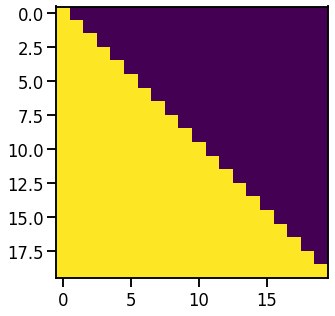

In [20]:
plt.figure(figsize=(5,5))
plt.imshow(subsequent_mask(20)[0])
None

### Attention

An attention function can be described as mapping a query and a set of key-value pairs to an output, where the query, keys, values, and output are all vectors. The output is computed as a weighted sum of the values, where the weight assigned to each value is computed by a compatibility function of the query with the corresponding key.

We call out particular attention "Scaled Dot-Product Attention". The input consists of queries and keys of dimension d<sub>k</sub>, and values of dimension d<sub>v</sub>. We compute the dot products of the query with all keys, divide each by sqrt(d<sub>k</sub>), and apply a softmax function to obtain the weights on the values.

In practice, we compute the attention function on a set of queries simultaneously, packed together into a matrix Q. The keys and values are also packed together into matrices K and V. We compute the matrix of outputs as:

__`Attention(Q, K, V) = softmax(  QK^T / sqrt(d_k) ) * V`__

In [0]:
def attention(query, key, value, mask=None, dropout=None):
  qk = torch.mm(query, key)
  scale = (qk - qk.mean()) / (qk.std + eps)
  m = torch.mm(scale, mask)
  drop = F.dropout(m, dropout)
  soft = F.softmax(drop)
  return torch.mm(soft, value)

  "Compute 'Scaled Dot Product Attention'"
  d_k = query.size(-1)
  scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
  if mask is not None:
    scores = scores.masked_fill(mask == 0, -1e9)
  p_attn = F.softmax(scores, dim=-1)
  if dropout is not None:
    p_attn = dropout(p_attn)
  return torch.matmul(p_attn, value), p_attn

The two most commonly used attention functions are additive attention, and dot-product (multiplicative) attention. Dot-product attention is identical to our algorithm, except for the scaling factor of 1/sqrt(dk). Additive attention computes the compatibility function using a feed-forward network with a single hidden layer. While the two are similar in theoretical complexity, __dot-product attention is much faster and more space-efficient in practice__, since it can be __implemented using highly optimized matrix multiplication code__.

While for small values of dk, the two mechanisms perform similarly, additive attention outperforms dot product attention without scaling for larger values of dk. We suspect that for large values of dk, the dot products grow large in magnitude, pushing the softmax function into regions where it has extremely small gradients (To illustrate why the dot products get large, assume that the components of q and k are independent random variables with mean 0 and variance 1. Then their dot product has mean 0 and variance dk). To counteract this effect, we scale the dot products by 1/sqrt(dk)).

Multi-head attention allows the model to jointly attend to information from different representation subspaces at different positions. With a single attention head, averaging inhibits this.

In this work we employ h = 8 parallel attention layers, or heads. For each of these we use dk = dv = dmodel / h = 64. Due to the reduced dimension of each head, the total computational cost is similar to that of single-head attention with full dimensionality.

In [0]:
class MultiHeadedAttention(nn.Module):
  def __init__(self, h, d_model, dropout=0.1):
    "Take in model size and number of heads."
    super(MultiHeadedAttention, self).__init__()
    assert d_model % h == 0
    # We assume d_v always equals d_k
    self.d_k = d_model // h
    self.h = h
    self.linears = clones(nn.Linear(d_model, d_model), 4)
    self.attn = None
    self.dropout = nn.Dropout(p=dropout)

  def forward(self, query, key, value, mask=None):
    "Implements Figure 2"
    if mask is not None:
      # Same mask applied to all h heads.
      mask = mask.unsqueeze(1)
    nbatches = query.size(0)

    # 1) Do all the linear projections in batch from d_model => h x d_k
    query, key, value = \
        [l(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
         for l, x in zip(self.linears, (query, key, value))]

    # 2) Apply attention on all the projected vectors in batch.
    x, self.attn = attention(query, key, value, mask=mask, dropout=self.dropout)

    # 3) "Concat" using a view and apply a final linear.
    x = x.transpose(1, 2).contiguous() \
         .view(nbatches, -1, self.h * self.d_k)
    return self.linears[-1](x)